In [1]:
# Data & Visualisasi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import itertools
import time
import warnings
from collections import Counter
from PIL import Image

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
warnings.filterwarnings('ignore')

2025-06-23 21:28:27.770827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750714107.959945      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750714108.019040      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set image size and batch size
IMG_SIZE = (255, 255)
BATCH_SIZE = 32

# ImageNet mean and std for normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def normalize_image(img):
    img = tf.cast(img, tf.float32) / 255.0
    img = (img - IMAGENET_MEAN) / IMAGENET_STD
    return img

def random_rotate(image):
    # Rotasi acak dengan rotasi 0°, 90°, 180°, atau 270° (kelipatan 90)
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    return tf.image.rot90(image, k)

def preprocess_train(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = random_rotate(image)  # rotasi kelipatan 90 derajat
    image = normalize_image(image)
    return image, label

def preprocess_eval(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = normalize_image(image)
    return image, label

In [3]:
for dirname, _, _ in os.walk("/kaggle/input"):
    print(dirname)

/kaggle/input
/kaggle/input/diagnosis-of-diabetic-retinopathy
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/valid
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/valid/DR
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/valid/No_DR
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/test
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/test/DR
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/test/No_DR
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train/DR
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train/No_DR
/kaggle/input/diagnosis-of-diabetic-reti

In [4]:
# Dataset paths
data_dir = "/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy"

# Load datasets
train_set = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
).map(preprocess_train).shuffle(1000).prefetch(tf.data.AUTOTUNE)

val_set = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/valid",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
).map(preprocess_eval).prefetch(tf.data.AUTOTUNE)

test_set = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
).map(preprocess_eval).prefetch(tf.data.AUTOTUNE)

Found 2076 files belonging to 2 classes.


I0000 00:00:1750714125.738262      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750714125.738943      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 531 files belonging to 2 classes.
Found 231 files belonging to 2 classes.


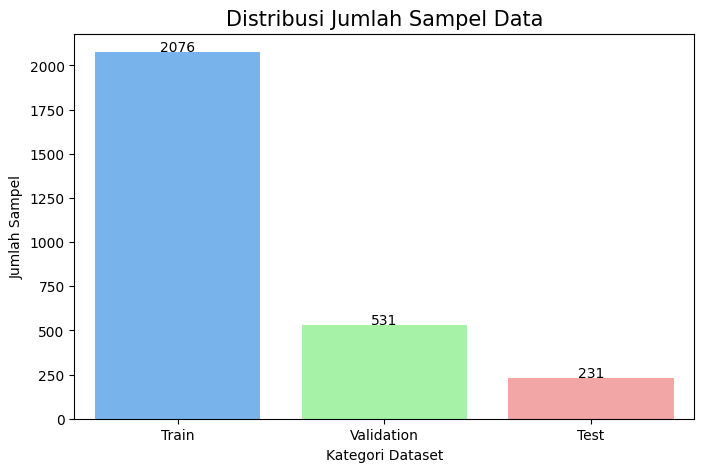

In [5]:
def total_samples(dataset):
    total = 0
    for images, labels in dataset:
        total += images.shape[0]
    return total
categories = ['Train', 'Validation', 'Test']
colors = ['#66b3ff', '#99ff99', '#ff9999']
counts_samples = [total_samples(train_set), total_samples(val_set), total_samples(test_set)]

plt.figure(figsize=(8, 5))
sns.barplot(x=categories, y=counts_samples, palette=colors)
plt.title('Distribusi Jumlah Sampel Data', fontsize=15)
plt.xlabel('Kategori Dataset')
plt.ylabel('Jumlah Sampel')
for i, count in enumerate(counts_samples):
    plt.text(i, count + 5, str(count), ha='center')
plt.show()

Found 2076 files belonging to 2 classes.


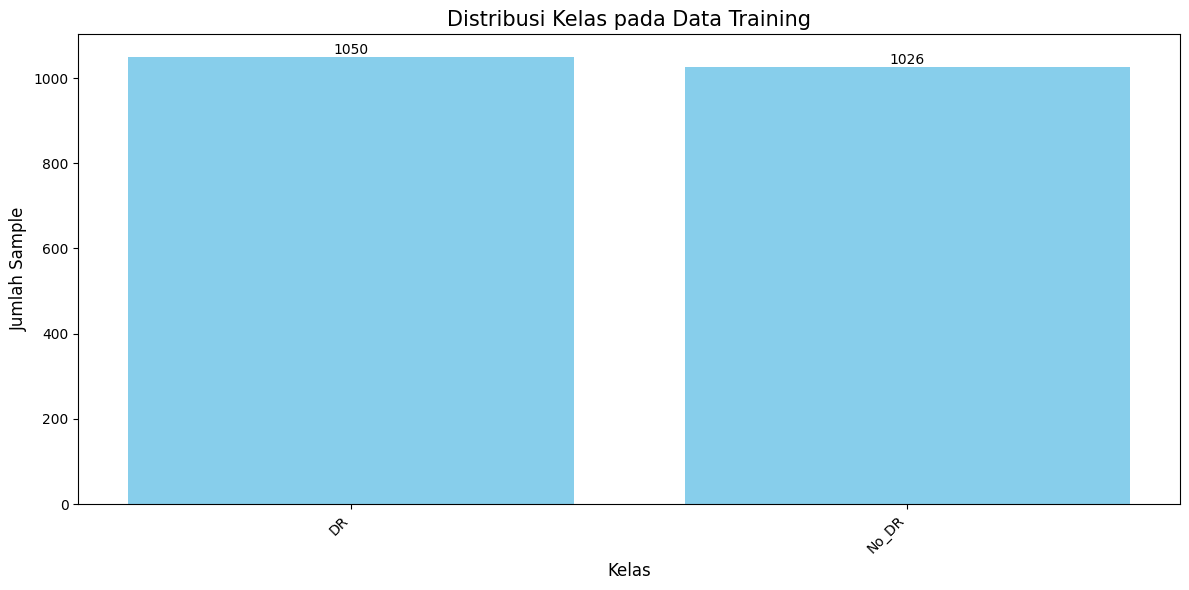

In [6]:
# Ambil class_names
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)
class_names = raw_train_ds.class_names

# Ambil semua label dari raw_train_ds
all_labels = []
for _, labels in raw_train_ds.unbatch():
    all_labels.append(int(labels.numpy()))

# Hitung distribusi label
class_counts = Counter(all_labels)

# Susun class_names dan counts sesuai urutan index label
class_names_sorted = [class_names[i] for i in sorted(class_counts.keys())]
counts = [class_counts[i] for i in sorted(class_counts.keys())]

# Visualisasi distribusi kelas
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names_sorted, counts, color='skyblue')

plt.title('Distribusi Kelas pada Data Training', fontsize=15)
plt.xlabel('Kelas', fontsize=12)
plt.ylabel('Jumlah Sample', fontsize=12)
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

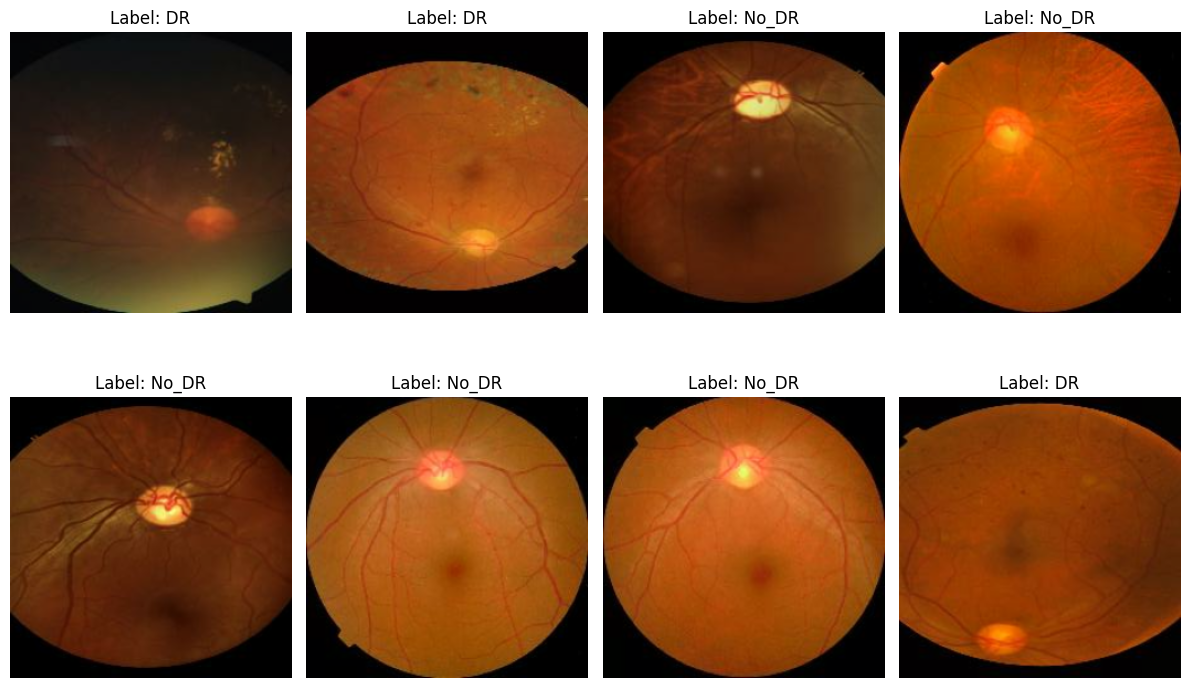

In [7]:
# Fungsi denormalisasi
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    return np.clip(img, 0, 1)

# Visualisasi sample image
plt.figure(figsize=(12, 8))

for images, labels in train_set.take(1):
    images = images.numpy()
    labels = labels.numpy()

    for i in range(8):
        img = denormalize(images[i])
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(255, 255, 3))
base_model.trainable = False  


cnn_branch = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(255,255,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten()
])

input_img = layers.Input(shape=(255,255,3))
effnet_features = base_model(input_img)
effnet_features = layers.GlobalAveragePooling2D()(effnet_features)

cnn_features = cnn_branch(input_img)

combined = layers.concatenate([effnet_features, cnn_features])

x = layers.Dense(256, activation='relu')(combined)
x = layers.Dropout(0.5)(x)
output = layers.Dense(2, activation='softmax')(x)  

model = models.Model(inputs=input_img, outputs=output)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 255, 255, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 8, 8, 1280)     │      4,049,571 │ input_layer_2[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1280)           │              0 │ efficientnetb0[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 246016)         │         19,392 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 247296)         │              0 │ global_average_poolin… │
│                           │                        │                │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │     63,308,032 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2)              │            514 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 67,377,509 (257.02 MB)

 Trainable params: 63,327,938 (241.58 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
# Callbacks
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)

In [10]:
# Jalankan training
history = model.fit(
    train_set,               
    validation_data=val_set,
    epochs=30,              
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30


I0000 00:00:1750714180.772972      67 service.cc:148] XLA service 0x7c2d14002d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750714180.773927      67 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750714180.773963      67 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750714182.673922      67 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1750714184.990021      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750714185.172860      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 1/65 ━━━━━━━━━━━━━━━━━━━━ 43:53 41s/step - accuracy: 0.4688 - loss: 0.7669

I0000 00:00:1750714196.529154      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 3/65 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.5122 - loss: 2.9004

E0000 00:00:1750714199.865736      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750714200.042772      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.6751 - loss: 1.2611

E0000 00:00:1750714225.912718      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750714226.078442      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


65/65 ━━━━━━━━━━━━━━━━━━━━ 76s 551ms/step - accuracy: 0.6767 - loss: 1.2519 - val_accuracy: 0.8983 - val_loss: 0.2422 - learning_rate: 1.0000e-04
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.8807 - loss: 0.2837 - val_accuracy: 0.9134 - val_loss: 0.2231 - learning_rate: 1.0000e-04
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.9046 - loss: 0.2355 - val_accuracy: 0.9096 - val_loss: 0.2363 - learning_rate: 1.0000e-04
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.9071 - loss: 0.2314 - val_accuracy: 0.9190 - val_loss: 0.1956 - learning_rate: 1.0000e-04
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - accuracy: 0.9133 - loss: 0.2236 - val_accuracy: 0.9171 - val_loss: 0.2018 - learning_rate: 1.0000e-04
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.9131 - loss: 0.2312 - val_accuracy: 0.9228 - val_loss: 0.1834 - learning_rate: 1.0000e-04
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.92

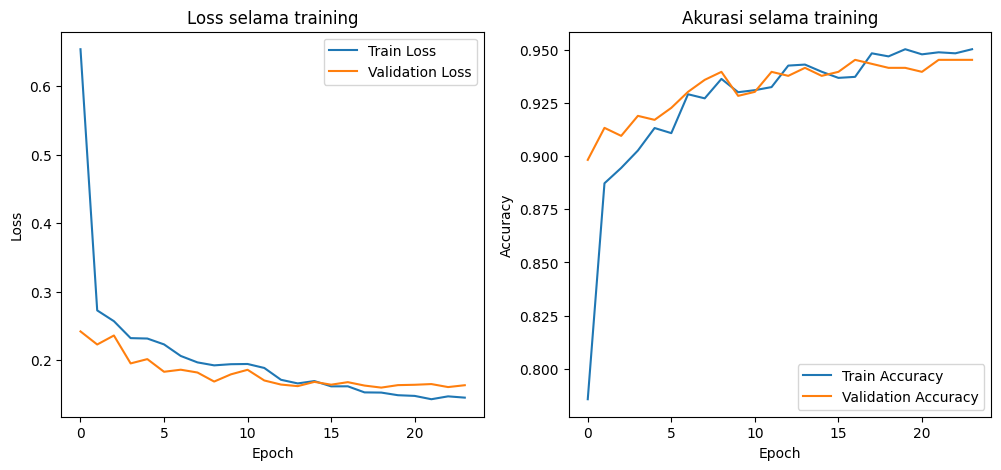

In [11]:
def plot_history(history):
    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss selama training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Akurasi selama training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_history(history)

In [12]:

y_true = []
y_pred = []

for images, labels in val_set:  
    preds = model.predict(images)
    preds_labels = preds.argmax(axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds_labels)


print(classification_report(y_true, y_pred))

f1 = f1_score(y_true, y_pred, average='macro')
print(f"F1-score (macro): {f1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       245
           1       0.93      0.97      0.95       286

    accuracy                           0.94       531
   macro avg       0.94      0.94      0.94       531
weighted avg       0.94      0.94      0.94       531

F1-score (macro): 0.9411
